# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from catboost import CatBoostClassifier

import optuna
import logging


**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip


In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [4]:
#your code here
df['Class'].mean() * 100

0.1727485630620034

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [5]:
#your code here

df['Hour'] = (df['Time'] // 3600) % 24
df['Day'] = (df['Time']) // (3600 * 24)

In [6]:
df['Day'].value_counts()

Day
0.0    144786
1.0    140021
Name: count, dtype: int64

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

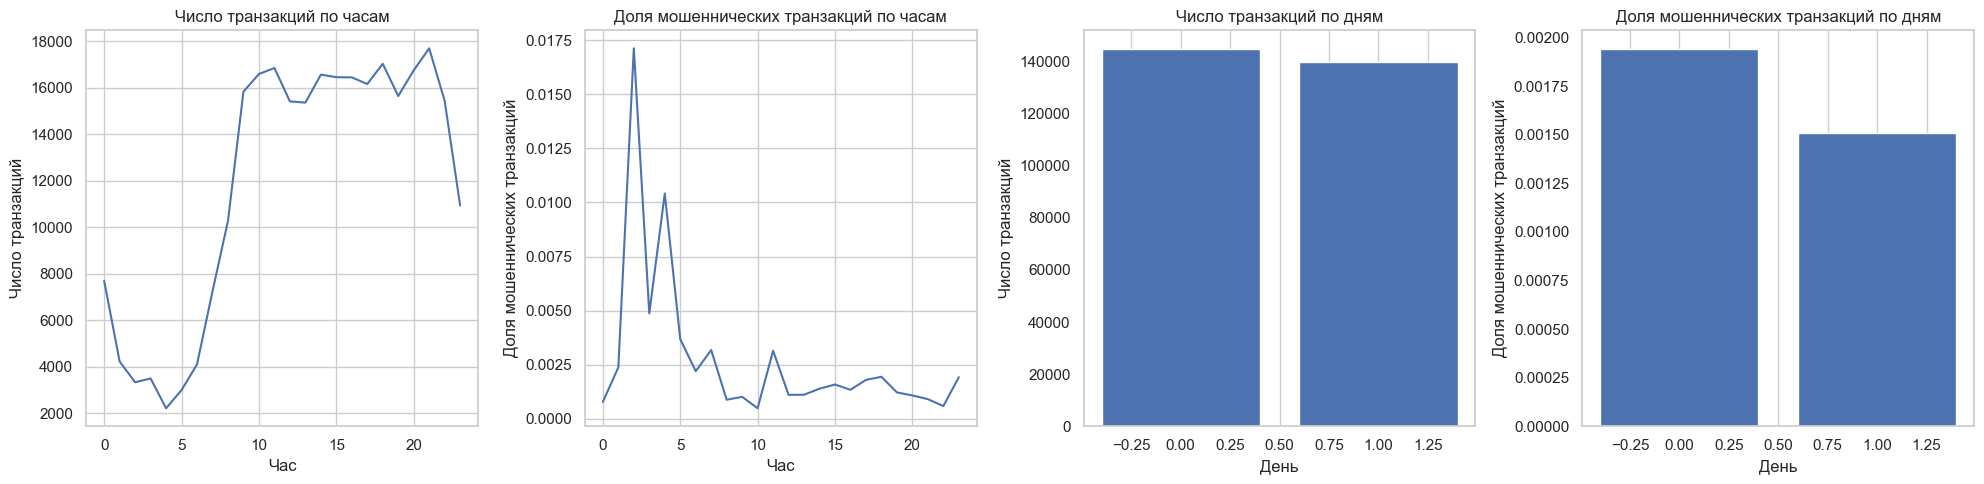

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

hourly_transactions = df.groupby('Hour').size()
axes[0].plot(hourly_transactions.index, hourly_transactions.values)
axes[0].set_title("Число транзакций по часам")
axes[0].set_xlabel("Час")
axes[0].set_ylabel("Число транзакций")
axes[0].grid(True)

hourly_fraud_transactions = df[df['Class'] == 1].groupby('Hour').size()
hourly_fraud_proportion = hourly_fraud_transactions / hourly_transactions
axes[1].plot(hourly_fraud_proportion.index, hourly_fraud_proportion.values)
axes[1].set_title("Доля мошеннических транзакций по часам")
axes[1].set_xlabel("Час")
axes[1].set_ylabel("Доля мошеннических транзакций")
axes[1].grid(True)

daily_transactions = df.groupby('Day').size()
axes[2].bar(daily_transactions.index, daily_transactions.values)
axes[2].set_title("Число транзакций по дням")
axes[2].set_xlabel("День")
axes[2].set_ylabel("Число транзакций")
axes[2].grid(axis='y')

daily_fraud_transactions = df[df['Class'] == 1].groupby('Day').size()
daily_fraud_proportion = daily_fraud_transactions / daily_transactions
axes[3].bar(daily_fraud_proportion.index, daily_fraud_proportion.values)
axes[3].set_title("Доля мошеннических транзакций по дням")
axes[3].set_xlabel("День")
axes[3].set_ylabel("Доля мошеннических транзакций")
axes[3].grid(axis='y')

plt.tight_layout()
plt.show()


С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

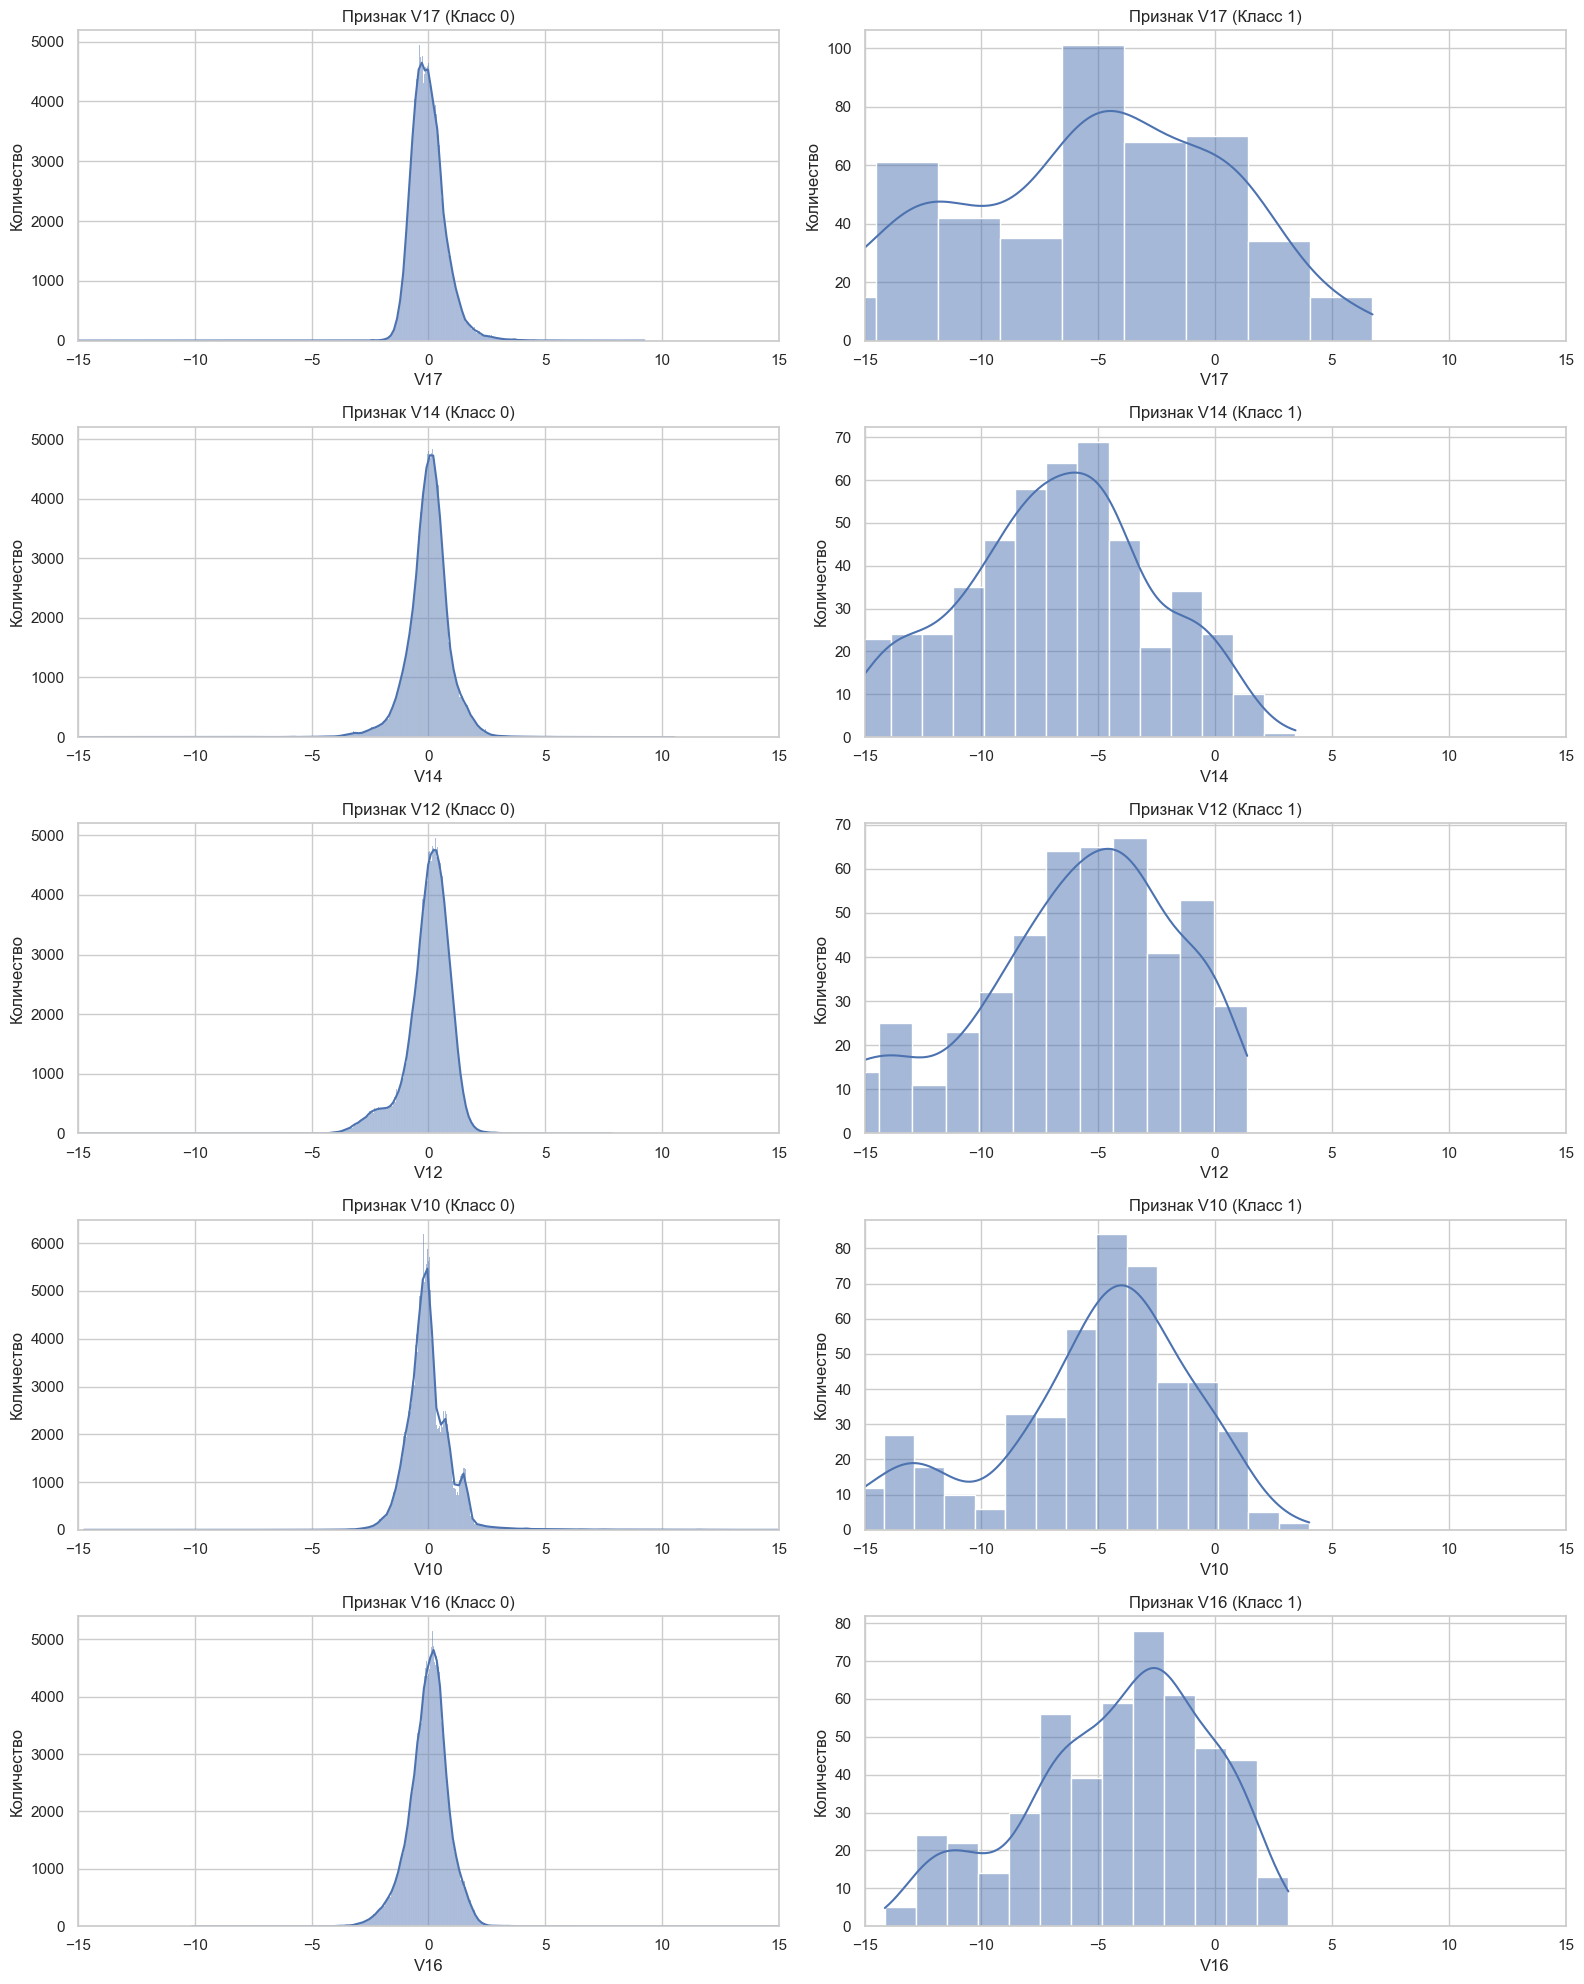

In [8]:
correlation = df.corr()['Class'].abs().sort_values(ascending=False)

top_features = correlation.index[1:6]

class_0 = df[df['Class'] == 0]
class_1 = df[df['Class'] == 1]

fig, axes = plt.subplots(len(top_features), 2, figsize=(16, 20))


for idx, feature in enumerate(top_features):
    sns.histplot(data=class_0, x=feature, kde=True, ax=axes[idx, 0])
    axes[idx, 0].set_title(f"Признак {feature} (Класс 0)")
    axes[idx, 0].set_xlabel(feature)
    axes[idx, 0].set_ylabel("Количество")
    axes[idx, 0].set_xlim(-15, 15)

    sns.histplot(data=class_1, x=feature, kde=True, ax=axes[idx, 1])
    axes[idx, 1].set_title(f"Признак {feature} (Класс 1)")
    axes[idx, 1].set_xlabel(feature)
    axes[idx, 1].set_ylabel("Количество")
    axes[idx, 1].set_xlim(-15, 15)

plt.tight_layout()
plt.show()


Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [9]:
df_sorted = df.sort_values(by='Time')


X = df_sorted.drop(['Class', 'Time'], axis=1)
y = df_sorted['Class']


test_size = 0.1  
split_idx = int(len(X) * (1 - test_size))
X_pretrain, X_test = X[:split_idx], X[split_idx:]
y_pretrain, y_test = y[:split_idx], y[split_idx:]


val_size = 1.0 / 9.0  
split_idx = int(len(X_pretrain) * (1 - val_size))
X_train, X_val = X_pretrain[:split_idx], X_pretrain[split_idx:]
y_train, y_val = y_pretrain[:split_idx], y_pretrain[split_idx:]


len(X_train), len(X_val), len(X_test)

(227845, 28481, 28481)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [10]:
#your code here

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [11]:
#your code here

def cohen_kappa_score(y_true, y_pred):
    n = len(y_true)

    p_o = sum(y_true == y_pred) / n

    p_pos = (sum(y_true) / n) * (sum(y_pred) / n)
    p_neg = ((n - sum(y_true)) / n) * ((n - sum(y_pred)) / n)
    p_e = p_pos + p_neg

    if p_e == 1:
        return 1.0
    else:
        kappa = (p_o - p_e) / (1 - p_e)
        return kappa

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [12]:
#your code here

def mcc(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    if denominator == 0:
        return 0

    mcc_value = numerator / denominator
    return mcc_value

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [13]:
#your code here
majority_class = df['Class'].mode()[0]

y_naive_pred = np.full(len(df), majority_class)

y_true = df['Class'].values

kappa_naive = cohen_kappa_score(y_true, y_naive_pred)
mcc_naive = mcc(y_true, y_naive_pred)

print("kappa naive:", kappa_naive)
print("mcc naive:", mcc_naive)


kappa naive: 0.0
mcc naive: 0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [14]:
from catboost import CatBoostClassifier

In [15]:
#your code here


cat_features = []


model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=4,
                           verbose=10)  


model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))


preds_class = model.predict(X_test)


0:	learn: 0.0079268	test: 0.0095258	best: 0.0095258 (0)	total: 90.1ms	remaining: 8.92s
10:	learn: 0.0025203	test: 0.0038361	best: 0.0038051 (5)	total: 222ms	remaining: 1.8s
20:	learn: 0.0020171	test: 0.0041572	best: 0.0037241 (13)	total: 354ms	remaining: 1.33s
30:	learn: 0.0016805	test: 0.0041504	best: 0.0037241 (13)	total: 476ms	remaining: 1.06s
40:	learn: 0.0014282	test: 0.0042307	best: 0.0037241 (13)	total: 602ms	remaining: 866ms
50:	learn: 0.0012311	test: 0.0041548	best: 0.0037241 (13)	total: 726ms	remaining: 698ms
60:	learn: 0.0010772	test: 0.0043690	best: 0.0037241 (13)	total: 853ms	remaining: 545ms
70:	learn: 0.0009201	test: 0.0041768	best: 0.0037241 (13)	total: 976ms	remaining: 399ms
80:	learn: 0.0007861	test: 0.0042883	best: 0.0037241 (13)	total: 1.1s	remaining: 259ms
90:	learn: 0.0006693	test: 0.0043920	best: 0.0037241 (13)	total: 1.23s	remaining: 121ms
99:	learn: 0.0005466	test: 0.0044175	best: 0.0037241 (13)	total: 1.35s	remaining: 0us

bestTest = 0.003724138042
bestIterati

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

In [16]:
preds_val = model.predict(X_val)
preds_test = model.predict(X_test)

mcc_val = mcc(y_val, preds_val)
kappa_val = cohen_kappa_score(y_val, preds_val)

mcc_test = mcc(y_test, preds_test)
kappa_test = cohen_kappa_score(y_test, preds_test)

print("Val:")
print("MCC:", mcc_val)
print("Kappa:", kappa_val)

print("\nTest:")
print("MCC:", mcc_test)
print("Kappa:", kappa_test)

Val:
MCC: 0.8135435465095795
Kappa: 0.8040386557486963

Test:
MCC: 0.7237392722838328
Kappa: 0.717758652842163


**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [17]:
#your code here

class_counts = y_train.value_counts()
weight_for_0 = class_counts[0] / class_counts[1]
weight_for_1 = 1.0


model_weighted = CatBoostClassifier(
    iterations=100,
    learning_rate=1,
    depth=4,
    class_weights=[weight_for_0, weight_for_1],
    verbose=10
)


model_weighted.fit(X_train, y_train, eval_set=(X_val, y_val))


preds_test_weighted = model_weighted.predict(X_test)
preds_val_weighted = model_weighted.predict(X_val)

mcc_test_weighted = mcc(y_test, preds_test_weighted)
kappa_test_weighted = cohen_kappa_score(y_test, preds_test_weighted)

mcc_val_weighted = mcc(y_val, preds_val_weighted)
kappa_val_weighted = cohen_kappa_score(y_val, preds_val_weighted)

print("Val:")
print("MCC:", mcc_val_weighted)
print("Kappa:", kappa_val_weighted)

print("\nTest:")
print("MCC:", mcc_test_weighted)
print("Kappa:", kappa_test_weighted)

0:	learn: 0.0001047	test: 0.0001138	best: 0.0001138 (0)	total: 16.5ms	remaining: 1.63s
10:	learn: 0.0000236	test: 0.0000274	best: 0.0000274 (10)	total: 148ms	remaining: 1.19s
20:	learn: 0.0000209	test: 0.0000254	best: 0.0000254 (20)	total: 285ms	remaining: 1.07s
30:	learn: 0.0000188	test: 0.0000236	best: 0.0000236 (28)	total: 414ms	remaining: 921ms
40:	learn: 0.0000176	test: 0.0000226	best: 0.0000226 (40)	total: 547ms	remaining: 788ms
50:	learn: 0.0000168	test: 0.0000216	best: 0.0000216 (50)	total: 676ms	remaining: 649ms
60:	learn: 0.0000163	test: 0.0000208	best: 0.0000208 (60)	total: 810ms	remaining: 518ms
70:	learn: 0.0000157	test: 0.0000201	best: 0.0000201 (70)	total: 936ms	remaining: 382ms
80:	learn: 0.0000153	test: 0.0000195	best: 0.0000195 (80)	total: 1.07s	remaining: 251ms
90:	learn: 0.0000148	test: 0.0000191	best: 0.0000191 (90)	total: 1.2s	remaining: 119ms
99:	learn: 0.0000146	test: 0.0000190	best: 0.0000190 (98)	total: 1.36s	remaining: 0us

bestTest = 1.903102743e-05
bestIter

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [18]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=1,
        depth=4,
        verbose=False
    )


    weight_coeff = trial.suggest_float('wc', 1.0, 100.0)
    

    sample_weight = np.where(y_train == 1, weight_coeff, 1)


    model.fit(X_train, y_train, sample_weight=sample_weight)


    preds_prob = model.predict_proba(X_val)[:, 1]  


    pr_auc = average_precision_score(y_val, preds_prob)
    return pr_auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


print("best_korf:", study.best_params['wc'])
print("best PR AUC:", study.best_value)


best_korf: 10.610077778798251
best PR AUC: 0.8397831613501022


In [19]:
best_weight = study.best_params['wc']

model = CatBoostClassifier(
    iterations=100,
    learning_rate=1,
    depth=4,
    class_weights=[1, best_weight],
    verbose=0
)
model.fit(X_pretrain, y_pretrain, sample_weight=np.where(y_pretrain == 1, best_weight, 1))

preds_test = model.predict(X_test)
preds_test_prob = model.predict_proba(X_test)[:, 1]

mcc = mcc(y_test, preds_test)
kappa = cohen_kappa_score(y_test, preds_test)


print("MCC:", mcc)
print("Kappa:", kappa)

MCC: 0.564937737544145
Kappa: 0.5551482982182482


In [20]:
best_weight = 12.20059610955728

model = CatBoostClassifier(
    iterations=100,
    learning_rate=1,
    depth=4,
    class_weights=[1, best_weight],
    verbose=0
)
model.fit(X_pretrain, y_pretrain, sample_weight=np.where(y_pretrain == 1, best_weight, 1))

def mcc(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    if denominator == 0:
        return 0
    return numerator / denominator


def objective(trial):
    prob_threshold = trial.suggest_float('prob_threshold', 0.0, 1.0)
    preds_prob = model.predict_proba(X_val)[:, 1]  
    preds_class = (preds_prob >= prob_threshold).astype(int) 
    return mcc(y_val, preds_class)  


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


print("best threshold:", study.best_params['prob_threshold'])
print("best MCC:", study.best_value)

best threshold: 0.9769392638238652
best MCC: 1.0


In [21]:
best_weight = 12.20059610955728
best_threshold = 0.9430854852052996


model = CatBoostClassifier(
    iterations=100,
    learning_rate=1,
    depth=4,
    verbose=False
)
model.fit(X_train, y_train, sample_weight=np.where(y_train == 1, best_weight, 1))


preds_prob = model.predict_proba(X_test)[:, 1]


preds_class = (preds_prob >= best_threshold).astype(int)

mcc_score = mcc(y_test, preds_class)
kappa_score = cohen_kappa_score(y_test, preds_class)

# Вывод результатов
print("MCC:", mcc_score)
print("Kappa:", kappa_score)

MCC: 0.6603693855677547
Kappa: 0.6484284570763339


In [22]:
best_weight = 12.20059610955728
best_threshold = 0.5  


model = CatBoostClassifier(
    iterations=100,
    learning_rate=1,
    depth=4,
    verbose=False
)
model.fit(X_train, y_train, sample_weight=np.where(y_train == 1, best_weight, 1))


preds_prob = model.predict_proba(X_test)[:, 1]


preds_class = (preds_prob >= best_threshold).astype(int)

mcc_score = mcc(y_test, preds_class)
kappa_score = cohen_kappa_score(y_test, preds_class)

# Вывод результатов
print("MCC:", mcc_score)
print("Kappa:", kappa_score)

MCC: 0.6845372504507213
Kappa: 0.6826996662053398


странно почему-то средний порог лучше найденног

видимо преобучился тк там 1 у мсс

поэтому улчше 05 использовать

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

!pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [23]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [24]:
#your code here
sampling_strategies = [1, 0.5, 0.1]  # 1:1, 1:2, 1:10

for strategy in sampling_strategies:
    print(f"\nSampling strategy: {strategy} (Minority:Majority)")
    sm = SMOTE(random_state=42, sampling_strategy=strategy)
    X_res, y_res = sm.fit_resample(X_train, y_train)


    model = CatBoostClassifier(
        iterations=100,
        learning_rate=1,
        depth=4,
        verbose=False
    )
    model.fit(X_res, y_res)


    preds_val = model.predict(X_val)
    preds_test = model.predict(X_test)


    val_kappa = cohen_kappa_score(y_val, preds_val)
    test_kappa = cohen_kappa_score(y_test, preds_test)
    val_mcc = mcc(y_val, preds_val)
    test_mcc = mcc(y_test, preds_test)

    print('Val Kappa:', val_kappa)
    print('Test Kappa:', test_kappa)
    print('Val MCC:', val_mcc)
    print('Test MCC:', test_mcc)


Sampling strategy: 1 (Minority:Majority)
Val Kappa: 0.5847538961891049
Test Kappa: 0.34014453804070854
Val MCC: 0.6028882033528554
Test MCC: 0.3929171281705363

Sampling strategy: 0.5 (Minority:Majority)
Val Kappa: 0.7187381186334466
Test Kappa: 0.5079979103512504
Val MCC: 0.7205215506808148
Test MCC: 0.5252920877651015

Sampling strategy: 0.1 (Minority:Majority)
Val Kappa: 0.8244458923572233
Test Kappa: 0.652765635791055
Val MCC: 0.8280298765168446
Test MCC: 0.6561966972262978


**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE
Идея: BorderlineSMOTE фокусируется на объектах минорного класса, которые находятся на границе разделения с мажорным классом. Вместо создания синтетических примеров для всех объектов минорного класса, метод генерирует их только для тех, что расположены вблизи границы с мажорным классом. Это позволяет улучшить классификацию в областях с высоким риском перекрытия классов и потенциальной ошибки.

SVM-SMOTE
Идея: SVM-SMOTE использует классификатор SVM для определения опорных векторов и затем применяет SMOTE только к этим выбранным опорным векторам. Таким образом, синтетические примеры создаются вблизи границы решения, что помогает уточнить границу и улучшить обобщающую способность модели.

K-Means-SMOTE
Идея: K-Means-SMOTE сначала применяет алгоритм кластеризации K-Means к данным минорного класса для выявления подгрупп. После этого SMOTE применяется внутри каждого кластера. Такой подход позволяет учесть внутреннюю структуру распределения минорного класса, что способствует более точному и разнообразному ресэмплингу.

ADASYN
Идея: ADASYN (Adaptive Synthetic Sampling) автоматически определяет количество синтетических примеров, которые нужно сгенерировать для каждого объекта минорного класса, основываясь на степени трудности классификации этих объектов. Чем сложнее объект классифицируется, тем больше синтетических примеров будет создано. Это помогает модели лучше научиться различать сложные случаи.

Теперь попробуйте сравнить качество всех методов на наших данных.

#your code here

from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
from sklearn.metrics import cohen_kappa_score, make_scorer
from catboost import CatBoostClassifier


def evaluate_model(X_train, y_train, X_val, y_val, method_name):
    model = CatBoostClassifier(iterations=100, learning_rate=1, depth=4, verbose=25)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, preds_val)
    print(f"{method_name} - Kappa: {kappa}")


for sampler, name in zip([BorderlineSMOTE(), SVMSMOTE(), KMeansSMOTE(), ADASYN()],
                         ["BorderlineSMOTE", "SVM-SMOTE", "KMeans-SMOTE", "ADASYN"]):
    sm = sampler
    X_res, y_res = sm.fit_resample(X_train, y_train)
    evaluate_model(X_res, y_res, X_val, y_val, name)


**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [25]:
from imblearn.under_sampling import RandomUnderSampler

Processed balance ratio 1.0000
Processed balance ratio 2.0000
Processed balance ratio 4.0000
Processed balance ratio 8.0000
Processed balance ratio 16.0000
Processed balance ratio 32.0000
Processed balance ratio 64.0000
Processed balance ratio 128.0000
Processed balance ratio 256.0000
Processed balance ratio 512.0000


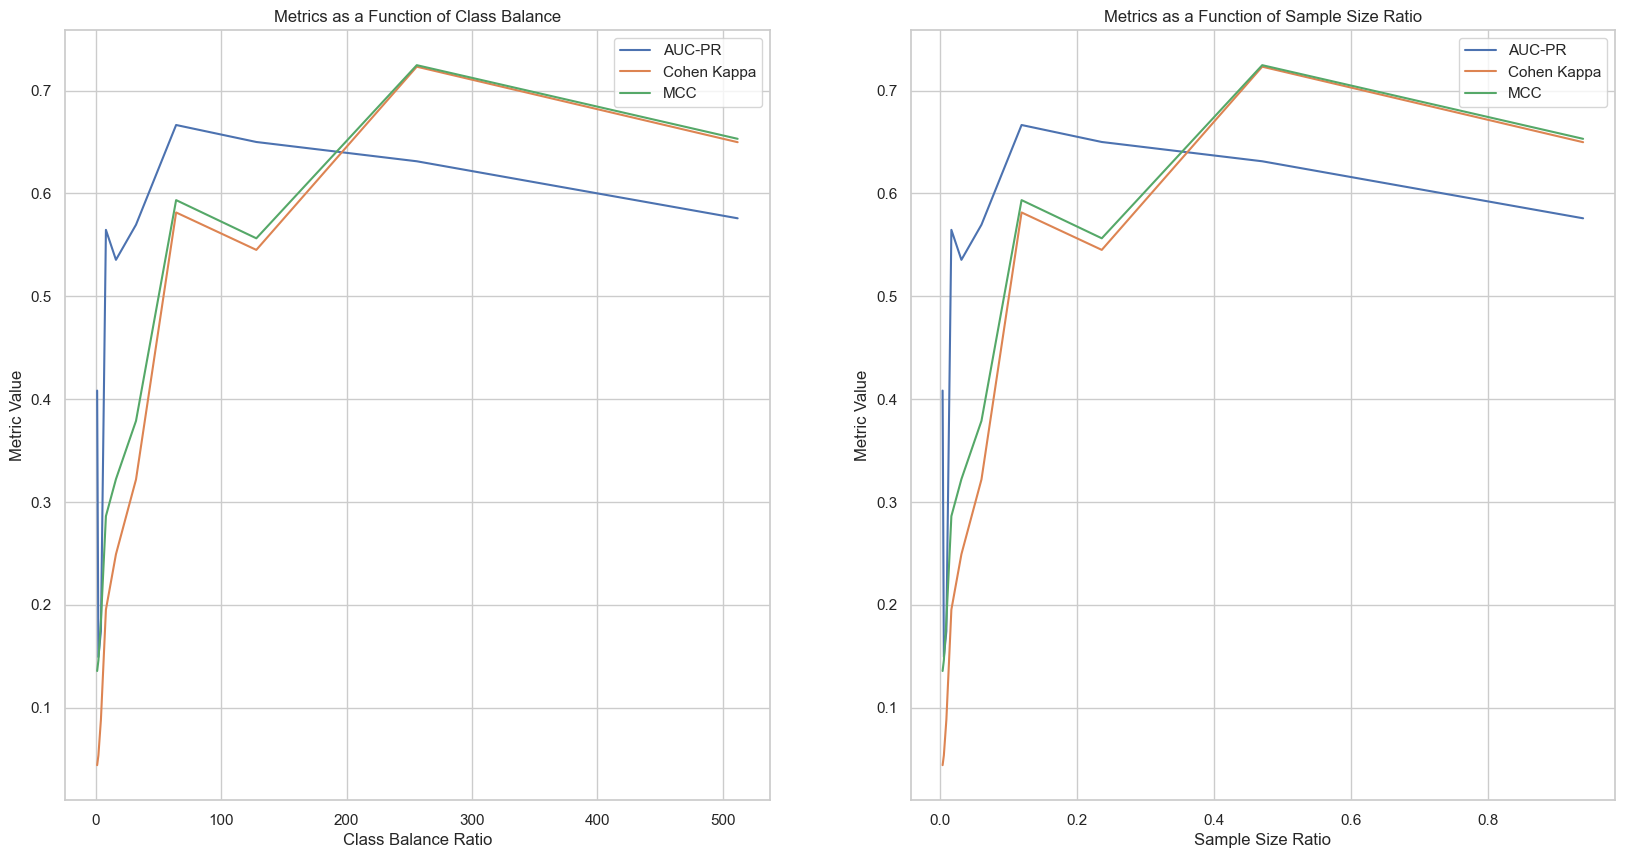

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve, cohen_kappa_score, matthews_corrcoef

log_scale_ratios = np.logspace(0, 9, base=2, num=10)
metrics = {'AUC_PR': [], 'Kappa': [], 'MCC': [], 'Size_Ratio': []}

for balance_ratio in log_scale_ratios:
    rus = RandomUnderSampler(sampling_strategy=1.0 / balance_ratio, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    metrics['Size_Ratio'].append(len(y_resampled) / len(y_train))
    
    model = CatBoostClassifier(iterations=100, learning_rate=1, depth=4, silent=True)
    model.fit(X_resampled, y_resampled, eval_set=(X_val, y_val))
    
    proba_preds = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, proba_preds)
    auc_pr = np.trapz(recall, precision)
    metrics['AUC_PR'].append(auc_pr)
    
    predicted_labels = (proba_preds > 0.5).astype(int)
    metrics['Kappa'].append(cohen_kappa_score(y_test, predicted_labels))
    metrics['MCC'].append(matthews_corrcoef(y_test, predicted_labels))
    
    print(f'Processed balance ratio {balance_ratio:.4f}')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(log_scale_ratios, metrics['AUC_PR'], label='AUC-PR')
plt.plot(log_scale_ratios, metrics['Kappa'], label='Cohen Kappa')
plt.plot(log_scale_ratios, metrics['MCC'], label='MCC')
plt.xlabel('Class Balance Ratio')
plt.ylabel('Metric Value')
plt.title('Metrics as a Function of Class Balance')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(metrics['Size_Ratio'], metrics['AUC_PR'], label='AUC-PR')
plt.plot(metrics['Size_Ratio'], metrics['Kappa'], label='Cohen Kappa')
plt.plot(metrics['Size_Ratio'], metrics['MCC'], label='MCC')
plt.xlabel('Sample Size Ratio')
plt.ylabel('Metric Value')
plt.title('Metrics as a Function of Sample Size Ratio')
plt.legend()
plt.grid(True)

plt.show()


Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

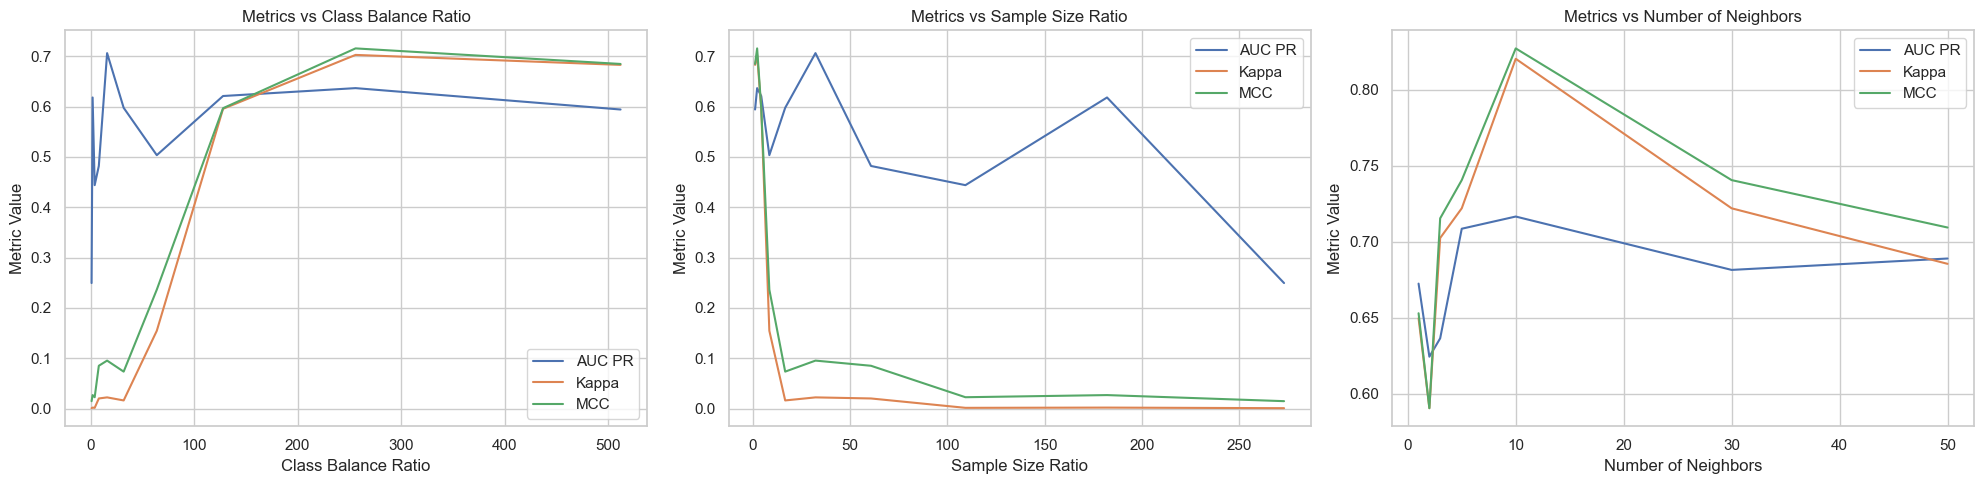

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import NearMiss
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import average_precision_score, cohen_kappa_score, matthews_corrcoef


balance_ratios = np.logspace(base=2.0, start=0, stop=9, num=10)

neighbors = [1, 2, 3, 5, 10, 30, 50]


results = {
    'Balance': [],
    'SizeRatio': [],
    'AUC_PR': [],
    'Kappa': [],
    'MCC': [],
    'Neighbor': [],
    'AUC_PR_N': [],
    'Kappa_N': [],
    'MCC_N': []
}

# Оценка различных балансов классов
for k in balance_ratios:
    sampling_strategy = {0: int(k * (y_train == 1).sum()), 1: (y_train == 1).sum()}
    nm = NearMiss(sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = nm.fit_resample(X_train, y_train)
    size_ratio = len(y_train) / len(y_resampled)
    clf = CatBoostClassifier()
    clf.fit(X_resampled, y_resampled, eval_set=Pool(X_val, y_val), verbose=False)
    y_pred = clf.predict_proba(X_test)[:, 1]


    results['Balance'].append(k)
    results['SizeRatio'].append(size_ratio)
    results['AUC_PR'].append(average_precision_score(y_test, y_pred))
    results['Kappa'].append(cohen_kappa_score(y_test, (y_pred > 0.5).astype(int)))
    results['MCC'].append(matthews_corrcoef(y_test, (y_pred > 0.5).astype(int)))

k_best = balance_ratios[np.argmax(results['MCC'])]  
for n in neighbors:
    sampling_strategy = {0: int(k_best * (y_train == 1).sum()), 1: (y_train == 1).sum()}
    nm = NearMiss(sampling_strategy=sampling_strategy, n_neighbors=n)
    X_resampled, y_resampled = nm.fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_resampled, y_resampled, eval_set=Pool(X_val, y_val), verbose=False)
    y_pred = clf.predict_proba(X_test)[:, 1]

    results['Neighbor'].append(n)
    results['AUC_PR_N'].append(average_precision_score(y_test, y_pred))
    results['Kappa_N'].append(cohen_kappa_score(y_test, (y_pred > 0.5).astype(int)))
    results['MCC_N'].append(matthews_corrcoef(y_test, (y_pred > 0.5).astype(int)))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(results['Balance'], results['AUC_PR'], label='AUC PR')
axes[0].plot(results['Balance'], results['Kappa'], label='Kappa')
axes[0].plot(results['Balance'], results['MCC'], label='MCC')
axes[0].set_xlabel('Class Balance Ratio')
axes[0].set_ylabel('Metric Value')
axes[0].set_title('Metrics vs Class Balance Ratio')
axes[0].legend()

axes[1].plot(results['SizeRatio'], results['AUC_PR'], label='AUC PR')
axes[1].plot(results['SizeRatio'], results['Kappa'], label='Kappa')
axes[1].plot(results['SizeRatio'], results['MCC'], label='MCC')
axes[1].set_xlabel('Sample Size Ratio')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('Metrics vs Sample Size Ratio')
axes[1].legend()

axes[2].plot(results['Neighbor'], results['AUC_PR_N'], label='AUC PR')
axes[2].plot(results['Neighbor'], results['Kappa_N'], label='Kappa')
axes[2].plot(results['Neighbor'], results['MCC_N'], label='MCC')
axes[2].set_xlabel('Number of Neighbors')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('Metrics vs Number of Neighbors')
axes[2].legend()

plt.tight_layout()
plt.show()


**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [28]:
from imblearn.under_sampling import TomekLinks
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, cohen_kappa_score, matthews_corrcoef

tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

model = CatBoostClassifier(iterations=100, learning_rate=1, depth=4, verbose=False)
model.fit(X_resampled, y_resampled)

predictions = model.predict(X_test)
prob_predictions = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, prob_predictions)
kappa = cohen_kappa_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)

print(f'ROC AUC: {roc_auc:.3f}, Kappa: {kappa:.3f}, MCC: {mcc:.3f}')


ROC AUC: 0.883, Kappa: 0.718, MCC: 0.724


In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

smt = SMOTETomek(smote=SMOTE(sampling_strategy=0.5), tomek=TomekLinks())
X_combined, y_combined = smt.fit_resample(X_train, y_train)

model_combined = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, verbose=False)
model_combined.fit(X_combined, y_combined)

predictions_combined = model_combined.predict(X_test)
prob_predictions_combined = model_combined.predict_proba(X_test)[:, 1]

roc_auc_combined = roc_auc_score(y_test, prob_predictions_combined)
kappa_combined = cohen_kappa_score(y_test, predictions_combined)
mcc_combined = matthews_corrcoef(y_test, predictions_combined)

print(f'Combined ROC AUC: {roc_auc_combined:.3f}, Kappa: {kappa_combined:.3f}, MCC: {mcc_combined:.3f}')


Combined ROC AUC: 0.977, Kappa: 0.592, MCC: 0.603


# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [30]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.stats import norm
from joblib import Parallel, delayed

def c_factor(n):
    if n > 1:
        return 2 * (np.log(n - 1) + np.euler_gamma) - 2 * (n - 1) / n
    if n == 1:
        return 1
    return 0

def calc_height(X, node):
    if node.kind == 'external':
        return node.depth
    else:
        side = np.dot(X, node.w) - node.b > 0
        next_node = node.right if side else node.left
        return calc_height(X, next_node)

class Node:
    def __init__(self, X, depth, max_features):
        self.depth = depth
        self.size = len(X)
        if self.size <= 1 or depth == 0:
            self.kind = 'external'
        else:
            self.kind = 'internal'
            self.w = np.random.randn(max_features)
            self.w /= np.linalg.norm(self.w, 2)
            self.b = np.median(np.dot(X, self.w))
            left_mask = np.dot(X, self.w) - self.b <= 0
            self.left = Node(X[left_mask], depth - 1, max_features)
            self.right = Node(X[~left_mask], depth - 1, max_features)

    def __repr__(self):
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(BaseEstimator):
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.root = None
    
    def fit(self, X):
        self.root = Node(X, self.max_depth, X.shape[1])
        return self

    def score_samples(self, X):
        return np.array([calc_height(x, self.root) for x in X])

class ExtendedIsolationForest(BaseEstimator):
    def __init__(self, n_trees=100, max_samples='auto', max_depth='auto', contamination=0.1, n_jobs=1):
        self.n_trees = n_trees
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.contamination = contamination
        self.n_jobs = n_jobs
        self.trees = []
    
    def fit(self, X):
        if self.max_samples == 'auto':
            self.max_samples = min(256, len(X))
        if self.max_depth == 'auto':
            self.max_depth = int(np.ceil(np.log2(self.max_samples)))
        
        self.trees = [RandomizedTree(max_depth=self.max_depth) for _ in range(self.n_trees)]
        for tree in self.trees:
            subsample_idx = np.random.choice(len(X), self.max_samples, replace=False)
            tree.fit(X[subsample_idx])
        return self

    def score_samples(self, X):
        scores = np.array([tree.score_samples(X) for tree in self.trees])
        path_lengths = np.mean(scores, axis=0)
        return path_lengths

    def predict(self, X):
        scores = self.score_samples(X)
        threshold = np.percentile(scores, 100 * (1 - self.contamination))
        return (scores > threshold).astype(int)


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

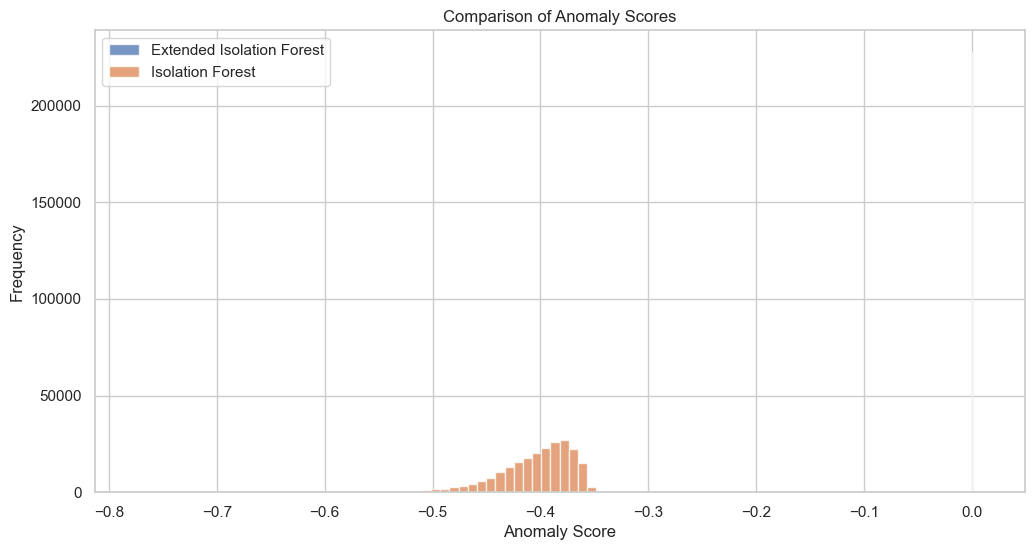

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


eif = ExtendedIsolationForest(n_trees=100, max_samples='auto', max_depth='auto', contamination=0.1, n_jobs=-1)
eif.fit(X_train_scaled)


scores_eif = eif.score_samples(X_train_scaled)


if_model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, n_jobs=-1)
if_model.fit(X_train_scaled)


scores_if = if_model.score_samples(X_train_scaled)


plt.figure(figsize=(12, 6))
plt.hist(scores_eif, bins=50, alpha=0.75, label='Extended Isolation Forest')
plt.hist(scores_if, bins=50, alpha=0.75, label='Isolation Forest')
plt.title("Comparison of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

тут какие-то беды с масштабом

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

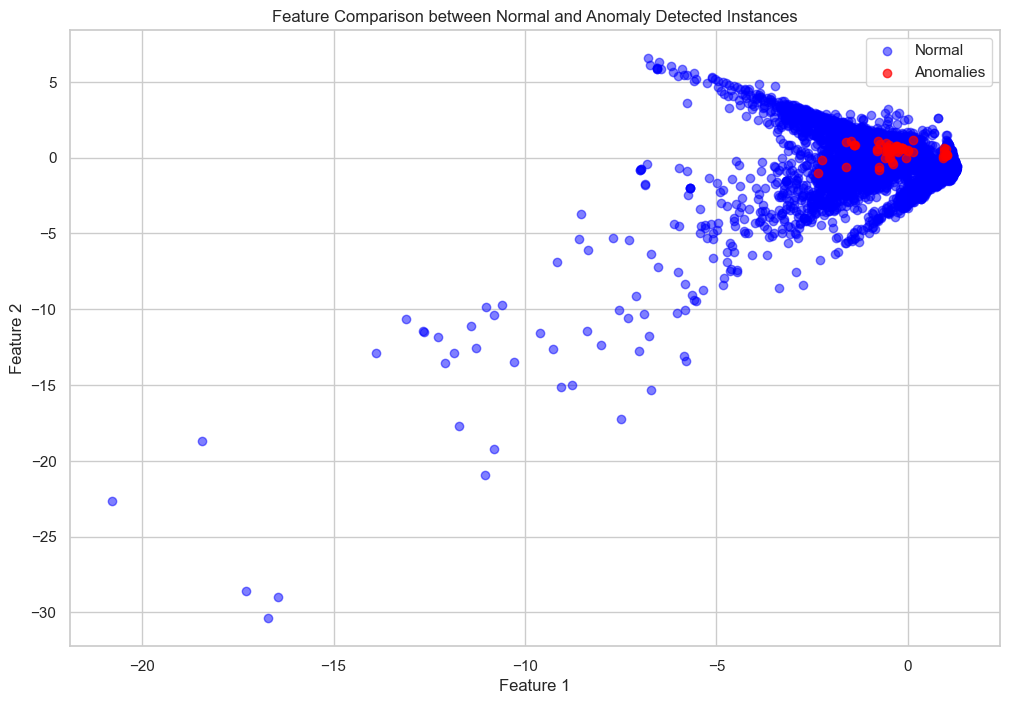

Characteristics of selected anomalies:
              0          1          2          3          4          5   \
count  59.000000  59.000000  59.000000  59.000000  59.000000  59.000000   
mean   -0.326191   0.404276  -0.961571  -0.420171   1.611416   2.075982   
std     0.780689   0.465913   0.836457   1.415579   1.042665   1.028519   
min    -2.332528  -1.008170  -2.533046  -2.347696  -0.853420  -1.063251   
25%    -0.601750   0.159712  -1.532032  -1.241459   1.197609   1.954948   
50%    -0.375939   0.483318  -0.974803  -1.106885   2.095183   2.375536   
75%    -0.076580   0.682100  -0.394855   0.125780   2.269744   2.584552   
max     1.035126   1.160970   1.196479   2.826597   3.111725   3.493573   

              6          7          8          9          10         11  \
count  59.000000  59.000000  59.000000  59.000000  59.000000  59.000000   
mean    0.005668   0.838441  -0.288339  -0.286789  -0.251281  -0.039411   
std     0.433365   0.413655   0.621768   0.727781   0.673802

In [33]:
scores_eif_val = eif.score_samples(X_val_scaled)  


threshold = np.percentile(scores_eif_val, 100 * (1 - 0.1))  


anomalies_indices = (scores_eif_val > threshold) & (y_val == 0)
anomalies = X_val_scaled[anomalies_indices]


fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c='blue', label='Normal', alpha=0.5)
ax.scatter(anomalies[:, 0], anomalies[:, 1], c='red', label='Anomalies', alpha=0.7)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()
plt.title('Feature Comparison between Normal and Anomaly Detected Instances')
plt.show()


print("Characteristics of selected anomalies:")
print(pd.DataFrame(anomalies).describe())


ну чего то вообще не понятно

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

вообще не учиться на полных данных, поэтому бууд использовать только часть 

In [35]:
from sklearn.model_selection import train_test_split

X_subsample, _, y_subsample, _ = train_test_split(
    X_train_scaled, y_train, train_size=0.1, random_state=42, stratify=y_train
)

In [36]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, contamination=0.01, novelty=True)


lof.fit(X_subsample)


y_pred = lof.predict(X_test_scaled)

kappa = cohen_kappa_score(y_test, y_pred)

mcc = matthews_corrcoef(y_test, y_pred)

print("kappa:", kappa)
print("mcc:", mcc)

kappa: -0.00021694639234781654
mcc: -0.020527191545879616


In [37]:
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
oc_svm.fit(X_subsample)

y_pred_oc_svm = oc_svm.predict(X_test_scaled)

y_pred_oc_svm = (y_pred_oc_svm == -1).astype(int)

kappa_oc_svm = cohen_kappa_score(y_test, y_pred_oc_svm)

mcc_oc_svm = matthews_corrcoef(y_test, y_pred_oc_svm)

print("kappa:", kappa_oc_svm)
print("mcc:", mcc_oc_svm)

kappa: 0.008847144321738276
mcc: 0.059397896150237724


У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [38]:
X_subsample, _, y_subsample, _ = train_test_split(
    X_train, y_train, train_size=0.3, random_state=42, stratify=y_train
)

In [39]:
#your code here
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
oc_svm.fit(X_train)
X_train['oneSVM'] = oc_svm.predict(X_train)
print(1)
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.01)
lof.fit(X_train)
X_train['LOF'] = lof.predict(X_train)
print(2)
isof = ExtendedIsolationForest(n_trees=100, max_samples='auto', max_depth='auto', contamination=0.1, n_jobs=-1)
X_train['IF'] = np.int32(isof.fit_predict(X_train) == -1)

/var/folders/nt/_5rbt10n3n7bbx1hrc_115700000gn/T/ipykernel_47800/2919654994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['oneSVM'] = oc_svm.predict(X_train)


1


/Users/maximzabelin/Library/Caches/pypoetry/virtualenvs/ml-hw-tOTRivSJ-py3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/var/folders/nt/_5rbt10n3n7bbx1hrc_115700000gn/T/ipykernel_47800/2919654994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['LOF'] = lof.predict(X_train)


2


AttributeError: 'ExtendedIsolationForest' object has no attribute 'fit_predict'

Не учится у меня эта штуковина

пусть так остается

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [ ]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)